In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from PIL import Image
import pandas as pd
from scipy.io import loadmat

In [ ]:
!git clone https://github.com/pjreddie/darknet
!cd darknet&&make

In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights


--2024-02-17 21:19:07--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: 'yolov3.weights'

yolov3.weights      100%[===================>] 236.52M  18.6MB/s    in 13s     

2024-02-17 21:19:20 (18.8 MB/s) - 'yolov3.weights' saved [248007048/248007048]



# Load YOLO

In [4]:

net = cv2.dnn.readNet("/kaggle/working/yolov3.weights", "/kaggle/working/darknet/cfg/yolov3.cfg")
layer_names = net.getUnconnectedOutLayersNames()

# Load the pre-trained face detection model from OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [10]:
df=pd.read_csv("/kaggle/input/celeba-dataset/list_attr_celeba.csv")
df1=pd.read_csv("/kaggle/input/celeba-dataset/list_bbox_celeba.csv")
df2=pd.read_csv("/kaggle/input/celeba-dataset/list_eval_partition.csv")
df3=pd.read_csv("/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv")


In [48]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.LANCZOS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = age_model.predict(ar)
        
    #print('Age:', int(age))
    return int(age)

# Load the saved model

In [70]:
gender_model = load_model('/kaggle/input/gender_detection_model.h5/keras/gender_detection_model.h5/1/gender_detection_model.h5')
age_model=load_model('/kaggle/input/agedetection/tensorflow2/age_detection_model/1/age_detection_model1.h5')
estimated_height=0
scaling_factor=10
# weights for face rating attributes
ATTRIBUTES_WEIGHTS = {
    "Facial Symmetry": 0.6,
    "Skin Texture": 0.4,
    "Proportions": 0.8,
    "Expression Analysis": 0.15,
    "Eye Clarity": 0.35
}

# Adjustments for specific facial attributes based on gender
ATTRIBUTE_ADJUSTMENTS = {
    "Double_Chin": {"Female": -0.25, "Male": 0},
    "Beard": {"Female": 0, "Male": 0.25}
}

# Placeholder function for face rating analysis
def analyze_face_rating(face_image, attributes, gender):
    rating = 5  # Base rating
    for attribute, weight in ATTRIBUTES_WEIGHTS.items():
        # Compute the impact of each attribute on the rating
        rating += attributes[attribute] * weight
    # Adjust rating based on specific facial attributes
    for attribute, adjustment in ATTRIBUTE_ADJUSTMENTS.items():
        rating += adjustment[gender] * attributes.get(attribute, 0)
    return rating

# Placeholder function for gender identification
def identify_gender(face_image):
    # Resize the face image to match the input shape of the gender identification model
    face_image_resized = cv2.resize(face_image, (128, 128))
    face_image_resized = cv2.cvtColor(face_image_resized, cv2.COLOR_BGR2RGB)
    face_image_resized = np.expand_dims(face_image_resized, axis=0)
    # Perform gender prediction
    gender_prediction = model.predict(face_image_resized)
    gender = "Female" if gender_prediction < 0.75 else "Male"
    return gender

# Face detection using YOLO

In [71]:



def detect_faces_yolo(frame):
    height, width, _ = frame.shape

    # Convert frame to blob
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(layer_names)

    # Get bounding boxes from YOLO output
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 0:  # Class 0 corresponds to 'person'
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maximum suppression to remove redundant boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    # Draw bounding boxes and for face detection using OpenCV Haar Cascade
    for i in range(len(indices)):
        index = indices[i]
        box = boxes[index]
        x, y, w, h = box

        # Extract the face region
        face_roi = frame[y:y+h, x:x+w]
        face_height = frame.shape[0]  # Calculate resized face height
        estimated_height = (face_height * scaling_factor )
        if estimated_height<=4000:
            estimated_height=5600*0.0264583333
        elif estimated_height>=7600:
            estimated_height=7600*0.0264583333
        else:
            estimated_height=estimated_height*0.0264583333
        # Check if the face region is not empty
        if face_roi.shape[0] > 0 and face_roi.shape[1] > 0:
            #  gender identification on the extracted face
            gender = identify_gender(face_roi)

            attributes = {
                "Facial Symmetry": np.random.uniform(0, 1),
                "Skin Texture": np.random.uniform(0, 1),
                "Proportions": np.random.uniform(0, 1),
                "Expression Analysis": np.random.uniform(0, 1),
                "Eye Clarity": np.random.uniform(0, 1),
                "Double_Chin": np.random.uniform(0, 1),  # Example attribute
                "Beard": np.random.uniform(0, 1)  # Example attribute
            }

            # face rating analysis
            face_rating = analyze_face_rating(face_roi, attributes, gender)
             

            '''# Output results
            print("Gender:", gender)
            print("Face Rating:", face_rating)
            print(f"Estimated Height:{estimated_height} cm")
     '''       # Draw a rectangle around the face for visualization
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 20)
    return frame,gender,face_rating,estimated_height

'''# Load an image
image_path = "/kaggle/input/validation/Male/652402_1969-01-18_2014.jpg"
detected_image = cv2.imread(image_path)
process_and_predict(image_path)
# Process the image
processed_image = detect_faces_yolo(detected_image)

# Display the processed image using matplotlib
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
'''

'# Load an image\nimage_path = "/kaggle/input/validation/Male/652402_1969-01-18_2014.jpg"\ndetected_image = cv2.imread(image_path)\nprocess_and_predict(image_path)\n# Process the image\nprocessed_image = detect_faces_yolo(detected_image)\n\n# Display the processed image using matplotlib\nplt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))\nplt.axis(\'off\')\nplt.show()\n'

1/1 [==============================] - 0s 82ms/step


/tmp/ipykernel_34/1928003133.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(age)


1/1 [==============================] - 0s 20ms/step


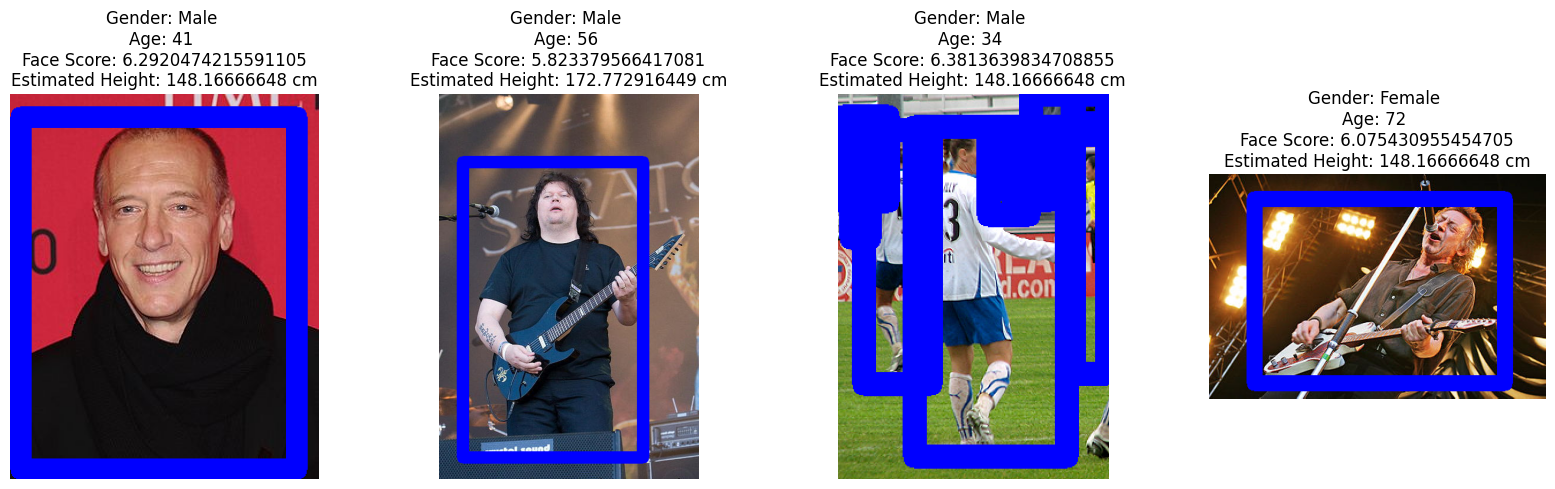

1/1 [==============================] - 0s 20ms/step


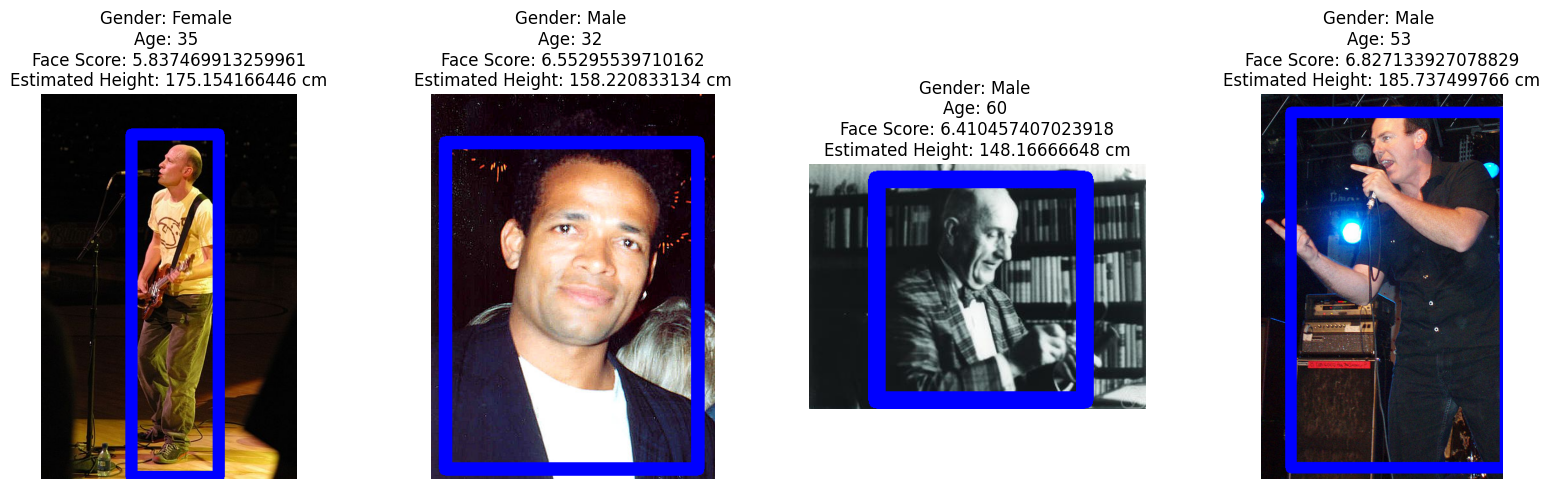

1/1 [==============================] - 0s 20ms/step


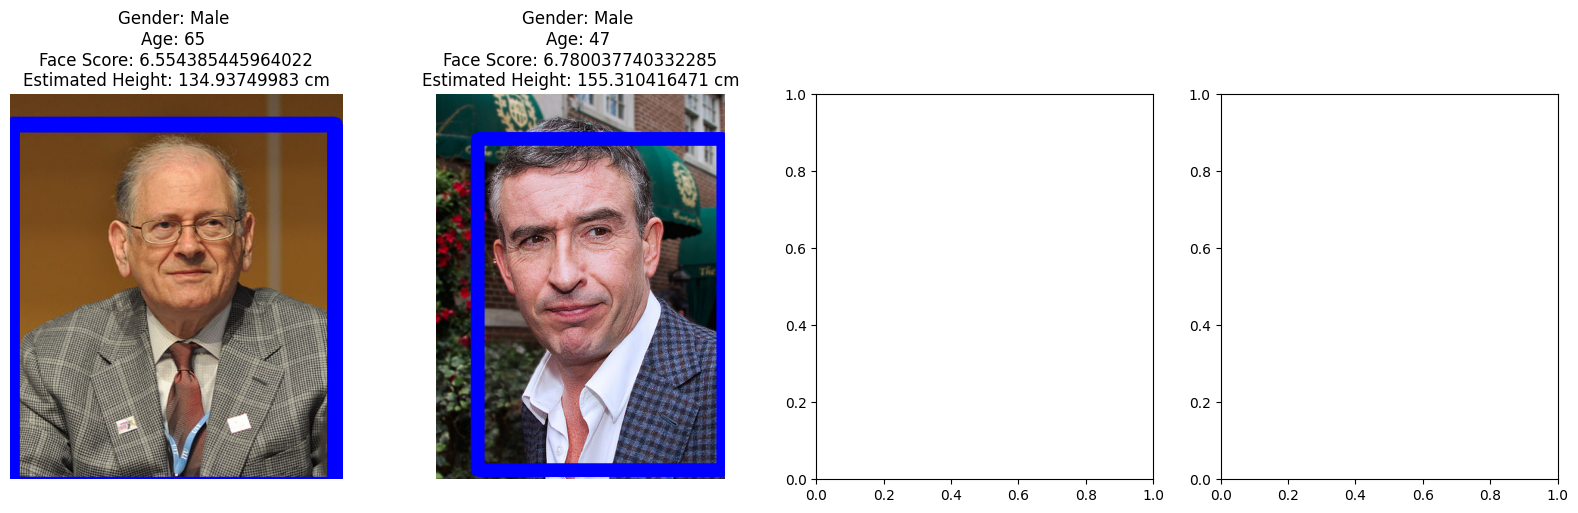

In [72]:
folder_path = "/kaggle/input/validation/Male"


fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Counter to keep track of images processed
image_count = 0

# Iterate through each file in the folder
for filename in os.listdir(folder_path)[28:38]:
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter only image files
        # Load an image
        image_path = os.path.join(folder_path, filename)
        detected_image = cv2.imread(image_path)

        # Process the image
        processed_image,gender,face_rating, estimated_height = detect_faces_yolo(detected_image)
        
        # Display the processed image using matplotlib
        axs[image_count % 4].imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
        axs[image_count % 4].axis('off')
        age=process_and_predict(image_path)
        # Construct the title string with all the information
        title = f"Gender: {gender} \nAge: {age} \nFace Score: {face_rating}\nEstimated Height: {estimated_height} cm"
        axs[image_count % 4].set_title(title)
        
        
        image_count += 1

        # If we have displayed 4 images, break to a new row
        if image_count % 4 == 0:
            plt.show()
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))

if image_count % 4 != 0:
    plt.show()


In [12]:
gender_labels=df['Male']
image_paths=df['image_id']


# Load and preprocess images

In [13]:

  
num_images_to_load = 15000 # Trained for only 15k images 


def load_and_preprocess_images(image_paths, dataset_path='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'):
    images = []

    for path_list in image_paths[:num_images_to_load]:
        img_path = os.path.join(dataset_path, path_list) if isinstance(path_list, str) else os.path.join(dataset_path, str(path_list))  # Constructing full file path using os.path.join

        if not os.path.isfile(img_path):
            print(f"Warning: File not found - {img_path}")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Unable to read image - {img_path}")
            continue

        img = cv2.resize(img, (128, 128))  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = img / 255.0  # Normalize pixel values
        images.append(img)

    return np.array(images)

images = load_and_preprocess_images(image_paths[:num_images_to_load])
gender_labels = gender_labels[:num_images_to_load]

# Print the number of samples
print(f"Number of samples in images: {len(images)}")
print(f"Number of samples in gender_labels_binary: {len(gender_labels)}")


Number of samples in images: 15000
Number of samples in gender_labels_binary: 15000


# spliting Dataset and Display the shapes of X_train and y_train with few examples

X_train shape: (12000, 128, 128, 3)
y_train shape: (12000,)

Example 1
Image:


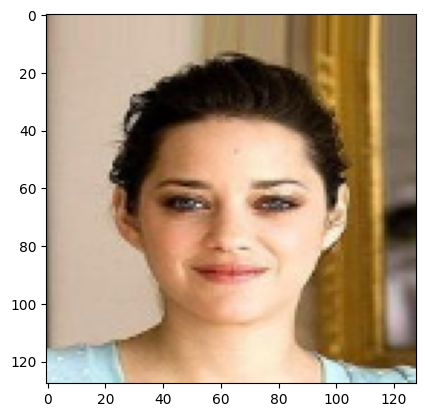

Gender: Female
One-Hot Encoded Label: 0

Example 2
Image:


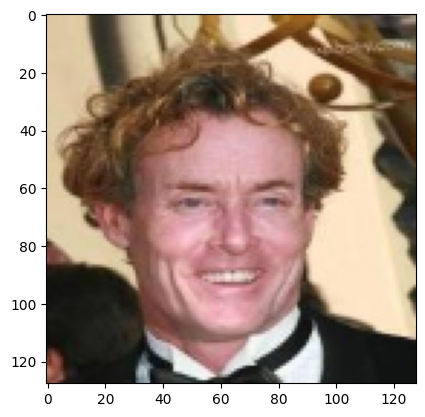

Gender: Male
One-Hot Encoded Label: 1

Example 3
Image:


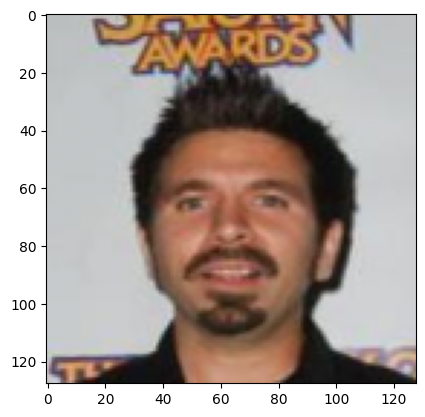

Gender: Male
One-Hot Encoded Label: 1

Example 4
Image:


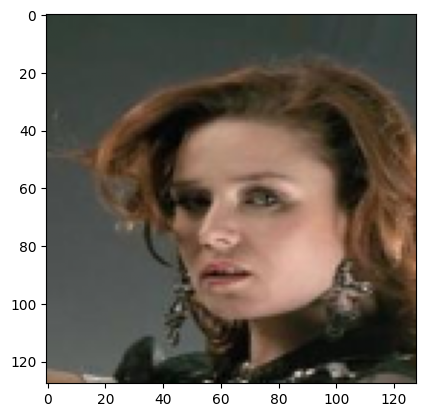

Gender: Female
One-Hot Encoded Label: 0


In [14]:
gender_labels_binary = np.where(gender_labels == -1, -1, 1)[:num_images_to_load]

# Assuming gender_labels_binary contains  gender labels with -1 for females and 1 for males
gender_labels_binary = np.where(gender_labels_binary == -1, 0, gender_labels_binary)

X_train, X_test, y_train, y_test = train_test_split(images, gender_labels_binary, test_size=0.2, random_state=42)

# Display the shapes of X_train and y_train
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
sample_indices = [0, 1, 2, 3]

# A few examples
for i in sample_indices:
    print("\nExample", i+1)
    print("Image:")
    plt.imshow(X_train[i])
    plt.show()
    print("Gender:", "Male" if y_train[i] == 1 else "Female")
    print("One-Hot Encoded Label:", y_train[i])


In [80]:
count_zeros = np.count_nonzero(gender_labels_binary == 0)

print("Total number of females in the training:", count_zeros)

Total number of females in the training: 8668


# Model architecture

In [15]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluation of the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50


I0000 00:00:1708205128.617191     316 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 13s 23ms/step - loss: 0.3420 - accuracy: 0.8409 - val_loss: 0.1825 - val_accuracy: 0.9320
Epoch 2/50
375/375 [==============================] - 6s 17ms/step - loss: 0.1540 - accuracy: 0.9436 - val_loss: 0.1349 - val_accuracy: 0.9510
Epoch 3/50
375/375 [==============================] - 6s 17ms/step - loss: 0.1205 - accuracy: 0.9528 - val_loss: 0.1323 - val_accuracy: 0.9513
Epoch 4/50
375/375 [==============================] - 6s 17ms/step - loss: 0.0953 - accuracy: 0.9633 - val_loss: 0.1196 - val_accuracy: 0.9570
Epoch 5/50
375/375 [==============================] - 6s 17ms/step - loss: 0.0791 - accuracy: 0.9700 - val_loss: 0.1155 - val_accuracy: 0.9597
Epoch 6/50
375/375 [==============================] - 6s 17ms/step - loss: 0.0623 - accuracy: 0.9774 - val_loss: 0.1222 - val_accuracy: 0.9567
Epoch 7/50
375/375 [==============================] - 6s 17ms/step - loss: 0.0482 - accuracy: 0.9811 - val_loss: 0.1328 - val_accuracy: 0.9560
Epoch 8/5

In [ ]:

model.save('gender_detection_model02.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('gender_detection_model0.h5')


In [74]:
from keras.models import load_model
model.save('gender_model01.keras')